## Results of Host Prediction
### Dataset: EMBL mapping, Vertebrates, Non-IDV

**Models**: FNN, CNN, RNN, LSTM, TF

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: 1036

**Classification**: Multi-class

**\# classes**: 5

**\# train samples** = 

**\# validation samples** = 

**\# test samples** = 

In [1]:
import seaborn

In [2]:
seaborn.__version__

'0.13.2'

In [3]:
import sys
import os
from pathlib import Path
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/miniconda3/envs/zoonosis/lib/python311.zip',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/lib-dynload',
 '',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../..']

In [31]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import mannwhitneyu, wilcoxon, ranksums, iqr

from src.utils import utils, evaluation_utils, visualization_utils

In [16]:
output_filepaths = {
    "LR": os.path.join(os.getcwd(), "..","..", "..", "..","output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240723/host_multi/kmer_k3_virus_host_name_multi__lr_output.csv"),
    "RF": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240723/host_multi/kmer_k3_virus_host_name_multi__rf_output.csv"),
    "SVM": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240723/host_multi/kmer_k3_virus_host_name_multi__svm_output.csv"),
    #"FNN": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240717/host_multi/nlp_no_msl_fnn-l_10-d_1024-lr1e-3_output.csv"),
    "CNN": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240717/host_multi/nlp_no_msl_cnn-l_4-d_1024-k3s1-lr1e-3_output.csv"),
    "RNN": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240717/host_multi/nlp_no_msl_rnn-l_6-d_1024-lr1e-5_output.csv"),
    "LSTM": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240722/host_multi/nlp_no_msl_lstm-l_2-d_1024-lr1e-3_output_mod.csv"),
    "ProtT5": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20250131/host_multi/external/uniref90viridae_prot_t5_xl_uniref50_msl2048_fnn_2l_d1024_lr3e-4_output.csv"),
    "ProstT5": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20241127/host_multi/external/uniref90viridae_prostt5_msl2048_bn_fnn_2l_d1024_lr3e-4_output.csv"),
    #"ESM2-t36_3B_UR50D" : os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20241127/host_multi/external/uniref90viridae_esm2_t36_3B_UR50D_bn_fnn_2l_d1024_lr1e-4_output.csv"),
    "ESM3": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20241127/host_multi/external/uniref90viridae_esm3_bn_fnn_2l_d1024_lr1e-4_output.csv"),
    #"ESM2": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20241124/host_multi/external/uniref90viridae_esm2_msl2048_bn_fnn_2l_d1024_lr1e-4_output.csv"),
    #"Transformer-Encoder": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240717/host_multi/nlp_no_msl_transformer-l_6-h_8-d_1024-msl2048-lr1e-4_output.csv"),
    #"ProteinBERT": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240827/proteinbert_prediction_results_20240827_231839.csv"),
    "VirProBERT": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240826/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_hybrid_attention_msl256s64ae_bn_fnn_2l_d1024_lr1e-4_output.csv")
    
}

In [18]:
def classwise_auprc_analysis(output_filepaths, figure_output_filepath=None):
    itr_col = "itr"
    experiment_col = "experiment"
    y_true_col = "y_true"
    auprc_results = []
    for model, output_filepath in output_filepaths.items():
        df = pd.read_csv(output_filepath, index_col=0)
        print(f"Read output {model} = {df.shape}")
        
        cols = df.columns
        classes = list(set(cols) - set([itr_col, experiment_col, y_true_col]))
        itrs = df[itr_col].unique()
    
        for itr in itrs:
            df_itr = df[df[itr_col] == itr]
            _, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=classes, y_true_col=y_true_col)
            auprcs_df["model"] = model
            auprcs_df["itr"] = itr
            auprc_results.append(auprcs_df)
    metadata = utils.compute_class_distribution(df_itr, y_true_col, format=False)
    metadata_formatted = utils.compute_class_distribution(df_itr, y_true_col, format=True)
    metadata_sorted = {}
    for k, v in metadata.items():
        metadata_sorted[metadata_formatted[k]] = v
    
    auprc_results_df = pd.concat(auprc_results, ignore_index=True)
    auprc_results_df.replace({"class":metadata_formatted}, inplace=True)
    sns.set_context("paper")
    sns.axes_style("whitegrid")
    
    FIGURE_CONFIG = {
        "figsize": (12, 6),
        "xtick.labelsize": 14,
        "ytick.labelsize": 14    
    }
    
    color_palette = sns.cubehelix_palette(start=3, rot=4.5, hue=1, gamma=0.9, dark=0.7, light=0.4, reverse=True, n_colors=auprc_results_df["model"].nunique())
    
    visualization_utils.pre_plot_config(FIGURE_CONFIG)
    ax = sns.boxplot(data=auprc_results_df, x="class", y="auprc", hue="model", 
                     order=metadata_sorted, linewidth=1.5, fliersize=5, linecolor="black",
                     palette=color_palette)
    
    bg_colors = [ "gray", "white",]
    
    plt.draw()
    
    ax.set_ylim(0, 1)
    ax.set_ylabel("AUPRC", size=14)
    ax.set_xlabel("", size=0, labelpad=0)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=False)
    plt.setp(ax.get_legend().get_texts(), fontsize=14)
    visualization_utils.wrap_ticklabels(ax, axis="x")
    
    n_classes = auprc_results_df["class"].nunique()
    for i in range(n_classes):
        ax.axvspan(i - .5, i + .5, color=bg_colors[i%2], alpha=0.2)
    
    if figure_output_filepath:
        visualization_utils.view(figure_output_filepath)
    plt.show()

Read output LR = (31690, 7)
Read output RF = (31690, 7)
Read output SVM = (31690, 7)
Read output CNN = (15845, 7)
Read output RNN = (15845, 7)
Read output LSTM = (15845, 7)
Read output ProtT5 = (15845, 7)
Read output ProstT5 = (15845, 7)
Read output ESM3 = (15845, 7)
Read output VirProBERT = (15845, 7)


/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../../../src/utils/visualization_utils.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped_labels, rotation=0)


<Figure size 640x480 with 0 Axes>

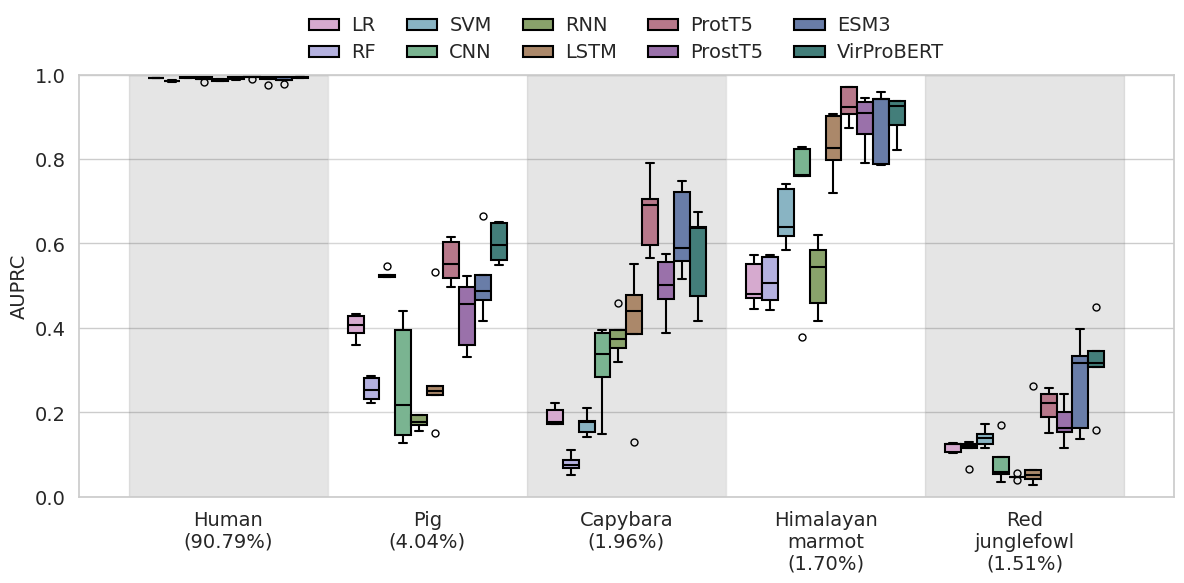

In [69]:
figure_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "output/visualization/temp_new/host_multi_all_models_classwise_aurpc_boxplot.pdf")
classwise_auprc_analysis(output_filepaths, figure_output_filepath)

In [67]:
def macro_and_classwise_auprc_analysis(output_filepaths, classes, figure_output_filepath=None):
    auprc_results = []
    classes = None
    
    for model, output_filepath in output_filepaths.items():
        df = pd.read_csv(output_filepath, index_col=0)
        print(f"Read output {model} = {df.shape}")
        
        cols = df.columns
        classes = list(set(cols) - set([itr_col, experiment_col, y_true_col]))
        itrs = df[itr_col].unique()
    
        for itr in itrs:
            df_itr = df[df[itr_col] == itr]
            _, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=classes, y_true_col=y_true_col)
            auprcs_df = pd.concat([auprcs_df, 
                                   pd.DataFrame({"class": ["Macro-AUPRC"], "auprc": [auprcs_df["auprc"].mean()]})
                                  ], ignore_index=True)
            auprcs_df["model"] = model
            auprcs_df["itr"] = itr
            auprc_results.append(auprcs_df)
    
    metadata = utils.compute_class_distribution(df_itr, y_true_col, format=False)
    metadata_formatted = utils.compute_class_distribution(df_itr, y_true_col, format=True)
    metadata_sorted = {}
    for k, v in metadata.items():
        metadata_sorted[metadata_formatted[k]] = v
    #metadata_sorted["Macro-AUPRC"] = 0
    auprc_results_df = pd.concat(auprc_results, ignore_index=True)
    auprc_results_df.replace({"class": metadata_formatted}, inplace=True)
    models = list(auprc_results_df["model"].unique())
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    plt.rcParams.update({'font.size': 18})
    fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharex=False, sharey=True, gridspec_kw={"width_ratios": [1, 3]})
    color_palette = sns.cubehelix_palette(start=3, rot=4.5, hue=1, gamma=0.9, dark=0.7, light=0.4, reverse=True, n_colors=auprc_results_df["model"].nunique())

    sns.boxplot(data=auprc_results_df[auprc_results_df["class"] == "Macro-AUPRC"], x="class", y="auprc", hue="model", fill=True,
                palette=color_palette, ax=axs[0],
                linewidth=1.5, fliersize=5, linecolor="black", legend=False)
    
    sns.boxplot(data=auprc_results_df[auprc_results_df["class"].isin(metadata_formatted.values())], x="class", y="auprc", hue="model", linewidth=1.5, fliersize=5, linecolor="black", order=metadata_sorted, palette=color_palette, ax=axs[1])
    #sns.violinplot(data=auprc_results_df[auprc_results_df["class"].isin(metadata_formatted.values())], x="class", y="auprc", hue="model", orient="v", order=metadata_sorted, palette=color_palette, ax=axs[1], legend="auto")
    # plt.draw()
    axs[0].set_ylim(0.0, 1)
    axs[1].set_ylim(0.0, 1)
    axs[0].set_ylabel("AUPRC", size=20)
    axs[0].set_xlabel("", size=0, labelpad=0)
    axs[1].set_xlabel("", size=0, labelpad=0)
    sns.move_legend(axs[1], "lower center", bbox_to_anchor=(.35, 1), ncol=5, title=None, frameon=False)
    plt.setp(axs[1].get_legend().get_texts(), fontsize=20)
    #visualization_utils.wrap_ticklabels(axs[0], axis="x")
    visualization_utils.wrap_ticklabels(axs[1], axis="x")

    bg_colors = [ "gray", "white",]
    
    for i in range(len(classes)):
        axs[1].axvspan(i - .5, i + .5, color=bg_colors[i%2], alpha=0.2)
    
    plt.subplots_adjust(wspace=0.01)
    plt.tight_layout()
    visualization_utils.view(figure_output_filepath)
    #plt.subplots_adjust(wspace=-1.5)
    plt.show()
    return auprc_results_df

Read output LR = (31690, 7)
Read output RF = (31690, 7)
Read output SVM = (31690, 7)
Read output CNN = (15845, 7)
Read output RNN = (15845, 7)
Read output LSTM = (15845, 7)
Read output ProtT5 = (15845, 7)
Read output ProstT5 = (15845, 7)
Read output ESM3 = (15845, 7)
Read output VirProBERT = (15845, 7)


/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../../../src/utils/visualization_utils.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped_labels, rotation=0)


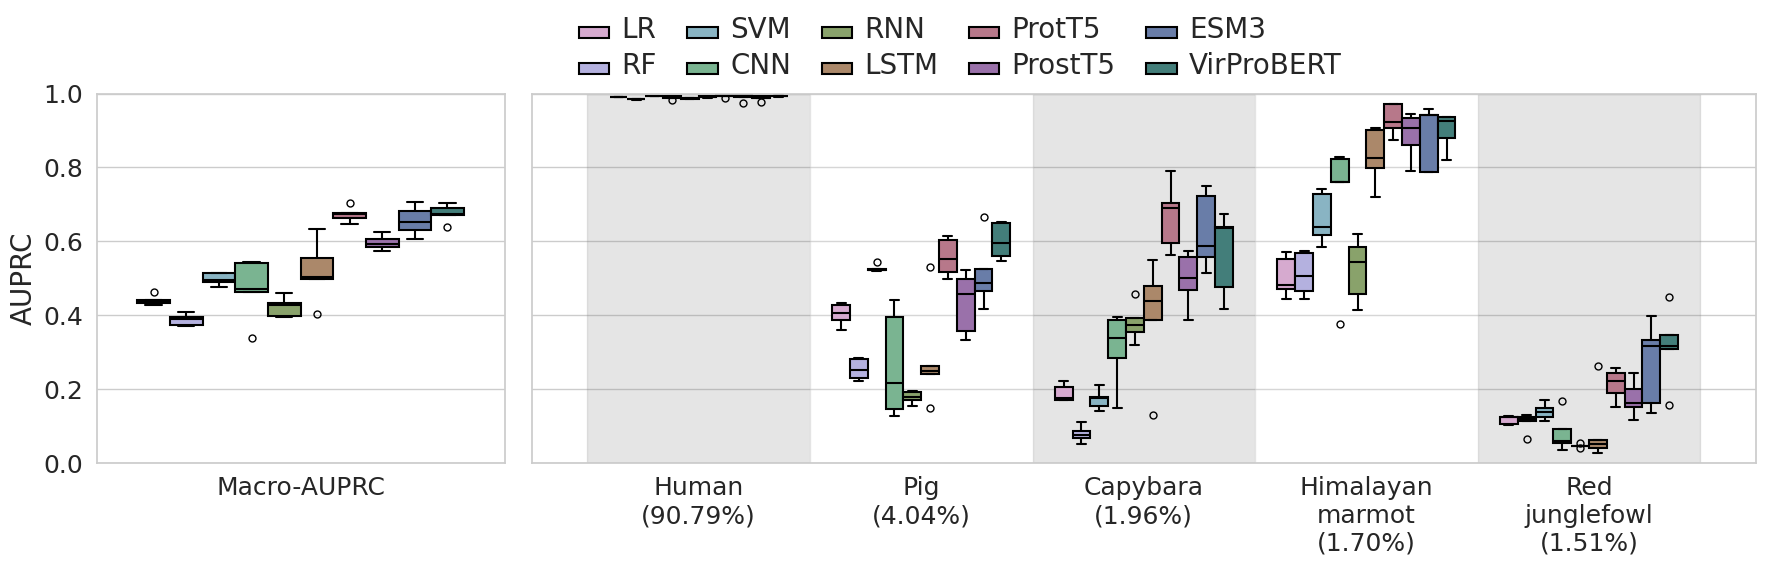

In [68]:
classes = ["Human", "Capybara", "Himalayan marmot", "Pig", "Red junglefowl"]
auprc_results_df = macro_and_classwise_auprc_analysis(output_filepaths, classes, 
                          figure_output_filepath=os.path.join(os.getcwd(), "..", "..", "..", "..", f"output/visualization/temp_new/host_multi_uniref90_combined_auprc.pdf"))

In [42]:
auprc_results_df[["model", "class", "auprc"]].groupby(["model", "class"]).agg(["mean", "std", "median", iqr])

auprc                              
                                         mean       std    median       iqr
model      class                                                           
CNN        Capybara (1.96%)          0.310939  0.100399  0.338699  0.102275
           Himalayan marmot (1.70%)  0.710000  0.188792  0.761065  0.063236
           Human (90.79%)            0.989391  0.004817  0.990173  0.004307
           Macro-AUPRC               0.471601  0.083857  0.471966  0.079258
           Pig (4.04%)               0.265663  0.143842  0.217168  0.247783
           Red junglefowl (1.51%)    0.082012  0.053274  0.058946  0.040436
ESM3       Capybara (1.96%)          0.626889  0.103108  0.588741  0.163702
           Himalayan marmot (1.70%)  0.883150  0.088069  0.941064  0.153537
           Human (90.79%)            0.987913  0.006760  0.988049  0.005344
           Macro-AUPRC               0.655855  0.039196  0.653017  0.051689
           Pig (4.04%)               0.511997  0.094105  0.487570  0.059626
           Red junglefowl (1.51%)    0.269325  0.113692  0.316952  0.170539
LR         Capybara (1.96%)          0.189589  0.022612  0.177348  0.033749
           Himalayan marmot (1.70%)  0.503898  0.054513  0.480751  0.080687
           Human (90.79%)            0.991283  0.000433  0.991137  0.000726
           Macro-AUPRC               0.441020  0.013635  0.437962  0.006465
           Pig (4.04%)               0.402781  0.030116  0.407621  0.039679
           Red junglefowl (1.51%)    0.117548  0.011577  0.124828  0.018269
LSTM       Capybara (1.96%)          0.396868  0.160613  0.439684  0.091612
           Himalayan marmot (1.70%)  0.830207  0.078200  0.825937  0.103544
           Human (90.79%)            0.990792  0.002894  0.991036  0.003564
           Macro-AUPRC               0.518839  0.084445  0.504004  0.055927
           Pig (4.04%)               0.287136  0.143470  0.250444  0.019698
           Red junglefowl (1.51%)    0.089193  0.098009  0.051380  0.021011
ProstT5    Capybara (1.96%)          0.497645  0.074245  0.500617  0.087507
           Himalayan marmot (1.70%)  0.887284  0.063449  0.907861  0.075147
           Human (90.79%)            0.989907  0.008670  0.994444  0.004928
           Macro-AUPRC               0.596748  0.020187  0.592882  0.022586
           Pig (4.04%)               0.433608  0.084238  0.456963  0.138202
           Red junglefowl (1.51%)    0.175295  0.048685  0.163546  0.048740
ProtT5     Capybara (1.96%)          0.669566  0.090406  0.690980  0.108472
           Himalayan marmot (1.70%)  0.929232  0.041850  0.922119  0.062779
           Human (90.79%)            0.994094  0.003287  0.994546  0.002364
           Macro-AUPRC               0.672491  0.021348  0.673640  0.013354
           Pig (4.04%)               0.556947  0.051548  0.552318  0.085812
           Red junglefowl (1.51%)    0.212616  0.042989  0.221004  0.054644
RF         Capybara (1.96%)          0.078824  0.022279  0.076203  0.018245
           Himalayan marmot (1.70%)  0.511055  0.058732  0.506254  0.102718
           Human (90.79%)            0.984707  0.001101  0.984886  0.001600
           Macro-AUPRC               0.388085  0.015864  0.389473  0.022648
           Pig (4.04%)               0.254578  0.028091  0.253077  0.049341
           Red junglefowl (1.51%)    0.111262  0.025766  0.120420  0.009621
RNN        Capybara (1.96%)          0.380006  0.051686  0.374096  0.040420
           Himalayan marmot (1.70%)  0.524389  0.085863  0.544204  0.127517
           Human (90.79%)            0.986832  0.002272  0.987715  0.003724
           Macro-AUPRC               0.423322  0.027061  0.428531  0.035506
           Pig (4.04%)               0.178179  0.016456  0.178030  0.023655
           Red junglefowl (1.51%)    0.047204  0.005706  0.046901  0.000896
SVM        Capybara (1.96%)          0.172497  0.026840  0.176038  0.025363
           Himalayan marmot (1.70%)  0.662138  0.069285  0.639447  0.110560
           H

In [29]:
auprc_results_df[auprc_results_df["class"] == "Human (90.79%)"]["auprc"].median()

0.9910864506709303

In [74]:
pairs = [("VirProBERT", "ESM3"),
        ("VirProBERT", "ProstT5"),
         ("VirProBERT", "ProtT5"),
         ("VirProBERT", "LSTM"),
         ("VirProBERT", "RNN"),
         ("VirProBERT", "CNN")]

def get_p_value_annotation(p_value):
    if p_value > 5e-2 and p_value <= 1:
        return "ns"
    elif p_value > 1e-2 and p_value <= 5e-2:
        return "*"
    elif p_value > 1e-3 and p_value <= 1e-2:
        return "**"
    elif p_value > 1e-4 and p_value <= 1e-3:
        return "***"
    elif p_value <= 1e-4:
        return "****"
    else:
        return None

def combined_auprc_analysis_w_stat(output_filepaths, figure_output_filepath=None):
    itr_col = "itr"
    experiment_col = "experiment"
    y_true_col = "y_true"
    auprc_results = []
    for model, output_filepath in output_filepaths.items():
        df = pd.read_csv(output_filepath, index_col=0)
        print(f"Read output {model} = {df.shape}")
        
        cols = df.columns
        classes = list(set(cols) - set([itr_col, experiment_col, y_true_col]))
        itrs = df[itr_col].unique()
    
        for itr in itrs:
            df_itr = df[df[itr_col] == itr]
            _, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=classes, y_true_col=y_true_col)
            auprcs_df = pd.concat([auprcs_df, 
                                   pd.DataFrame({"class": ["Macro-AUPRC"], "auprc": [auprcs_df["auprc"].mean()]})
                                  ], ignore_index=True)
            auprcs_df["model"] = model
            auprcs_df["itr"] = itr
            auprc_results.append(auprcs_df)
    
    metadata = utils.compute_class_distribution(df_itr, y_true_col, format=False)
    metadata_formatted = utils.compute_class_distribution(df_itr, y_true_col, format=True)
    metadata_sorted = {}
    for k, v in metadata.items():
        metadata_sorted[metadata_formatted[k]] = v
        
    #metadata_sorted["Macro-AUPRC"] = 0
    auprc_results_df = pd.concat(auprc_results, ignore_index=True)
    auprc_results_df.replace({"class": metadata_formatted}, inplace=True)
    models = list(auprc_results_df["model"].unique())
    print(models)
    auprc_results_df = pd.concat(auprc_results, ignore_index=True)
    auprc_results_df.replace({"class":metadata_formatted}, inplace=True)
    sns.set_context("paper")
    sns.axes_style("whitegrid")

    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    plt.rcParams.update({'font.size': 18})
    fig, axs = plt.subplots(2, 1, figsize=(14, 12))
    color_palette = sns.cubehelix_palette(start=3, rot=4.5, hue=1, gamma=0.9, dark=0.7, light=0.4, reverse=True, n_colors=auprc_results_df["model"].nunique())
    
    #visualization_utils.pre_plot_config(FIGURE_CONFIG)
    
    ############# First plot ###############
    sns.boxplot(data=auprc_results_df[auprc_results_df["class"] == "Macro-AUPRC"], x="model", y="auprc", hue="model", fill=True,
                palette=color_palette, ax=axs[0], order=models, legend=False,
                linewidth=1.5, fliersize=5, linecolor="black")
    sns.stripplot(data=auprc_results_df[auprc_results_df["class"] == "Macro-AUPRC"], x="model", y="auprc", ax=axs[0], color="black", size=8, alpha=.7,
                  order=models)


    for i, pair in enumerate(pairs):
        model_1_values = auprc_results_df[(auprc_results_df["class"] == "Macro-AUPRC") & (auprc_results_df["model"] == pair[0])]["auprc"].values
        model_2_values = auprc_results_df[(auprc_results_df["class"] == "Macro-AUPRC") & (auprc_results_df["model"] == pair[1])]["auprc"].values
        p_value = mannwhitneyu(model_1_values, model_2_values, alternative="two-sided").pvalue
        formatted_pvalue = f"p={p_value:.2e}"
        print(f"{pair}: p-value={formatted_pvalue}")
        
        x1 = models.index(pair[0])
        x2 = models.index(pair[1])
        y1 = max(model_1_values.max(), model_2_values.max()) + (0.06 * (i + 1))
        y2 = y1 + .01
        
        axs[0].plot([x1, x1, x2, x2], [y1, y2, y2, y1], lw=2, c="k")
        text = get_p_value_annotation(p_value)
        if text == "ns":
            axs[0].text((x1 + x2)*.5, y1+0.01, text , ha='center', va='bottom', color="k", size="18")
        else:
            axs[0].text((x1 + x2)*.5, y1, text, ha='center', va='bottom', color="k", size="18")

    
    axs[0].set_xlabel("", size=0, labelpad=0)
    axs[0].set_ylabel("Macro-AUPRC", size=20)
    axs[0].set_ylim(0, 1.1)

    ############# Second plot ###############
    sns.boxplot(data=auprc_results_df[auprc_results_df["class"].isin(metadata_formatted.values())], x="class", y="auprc", hue="model", 
                     order=metadata_formatted.values(), linewidth=1.5, fliersize=5, linecolor="black",
                     palette=color_palette, ax=axs[1])
    
    bg_colors = [ "gray", "white",]
        
    axs[1].set_ylim(0, 1)
    axs[1].set_ylabel("AUPRC", size=20)
    axs[1].set_xlabel("", size=0, labelpad=0)
    sns.move_legend(axs[1], "lower center", bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=False)
    plt.setp(axs[1].get_legend().get_texts(), fontsize=18)
    visualization_utils.wrap_ticklabels(axs[1], axis="x")
    
    n_classes = auprc_results_df["class"].nunique() - 1 # -1 to account for Macro-AUPRC
    for i in range(n_classes):
        axs[1].axvspan(i - .5, i + .5, color=bg_colors[i%2], alpha=0.2)

    axs[0].text(x=-1.5, y=1.1, s="A", fontsize=24, color="black")
    axs[1].text(x=-1.1, y=1.1, s="B", fontsize=24, color="black")
    axs[0].margins(0.01, tight=True)
    axs[1].margins(0.01, tight=True)
    if figure_output_filepath:
        plt.savefig(figure_output_filepath, bbox_inches="tight")
    plt.show()

Read output LR = (31690, 7)
Read output RF = (31690, 7)
Read output SVM = (31690, 7)
Read output CNN = (15845, 7)
Read output RNN = (15845, 7)
Read output LSTM = (15845, 7)
Read output ProtT5 = (15845, 7)
Read output ProstT5 = (15845, 7)
Read output ESM3 = (15845, 7)
Read output VirProBERT = (15845, 7)
['LR', 'RF', 'SVM', 'CNN', 'RNN', 'LSTM', 'ProtT5', 'ProstT5', 'ESM3', 'VirProBERT']
('VirProBERT', 'ESM3'): p-value=p=5.48e-01
('VirProBERT', 'ProstT5'): p-value=p=7.94e-03
('VirProBERT', 'ProtT5'): p-value=p=1.00e+00
('VirProBERT', 'LSTM'): p-value=p=7.94e-03
('VirProBERT', 'RNN'): p-value=p=7.94e-03
('VirProBERT', 'CNN'): p-value=p=7.94e-03


/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../../../src/utils/visualization_utils.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped_labels, rotation=0)


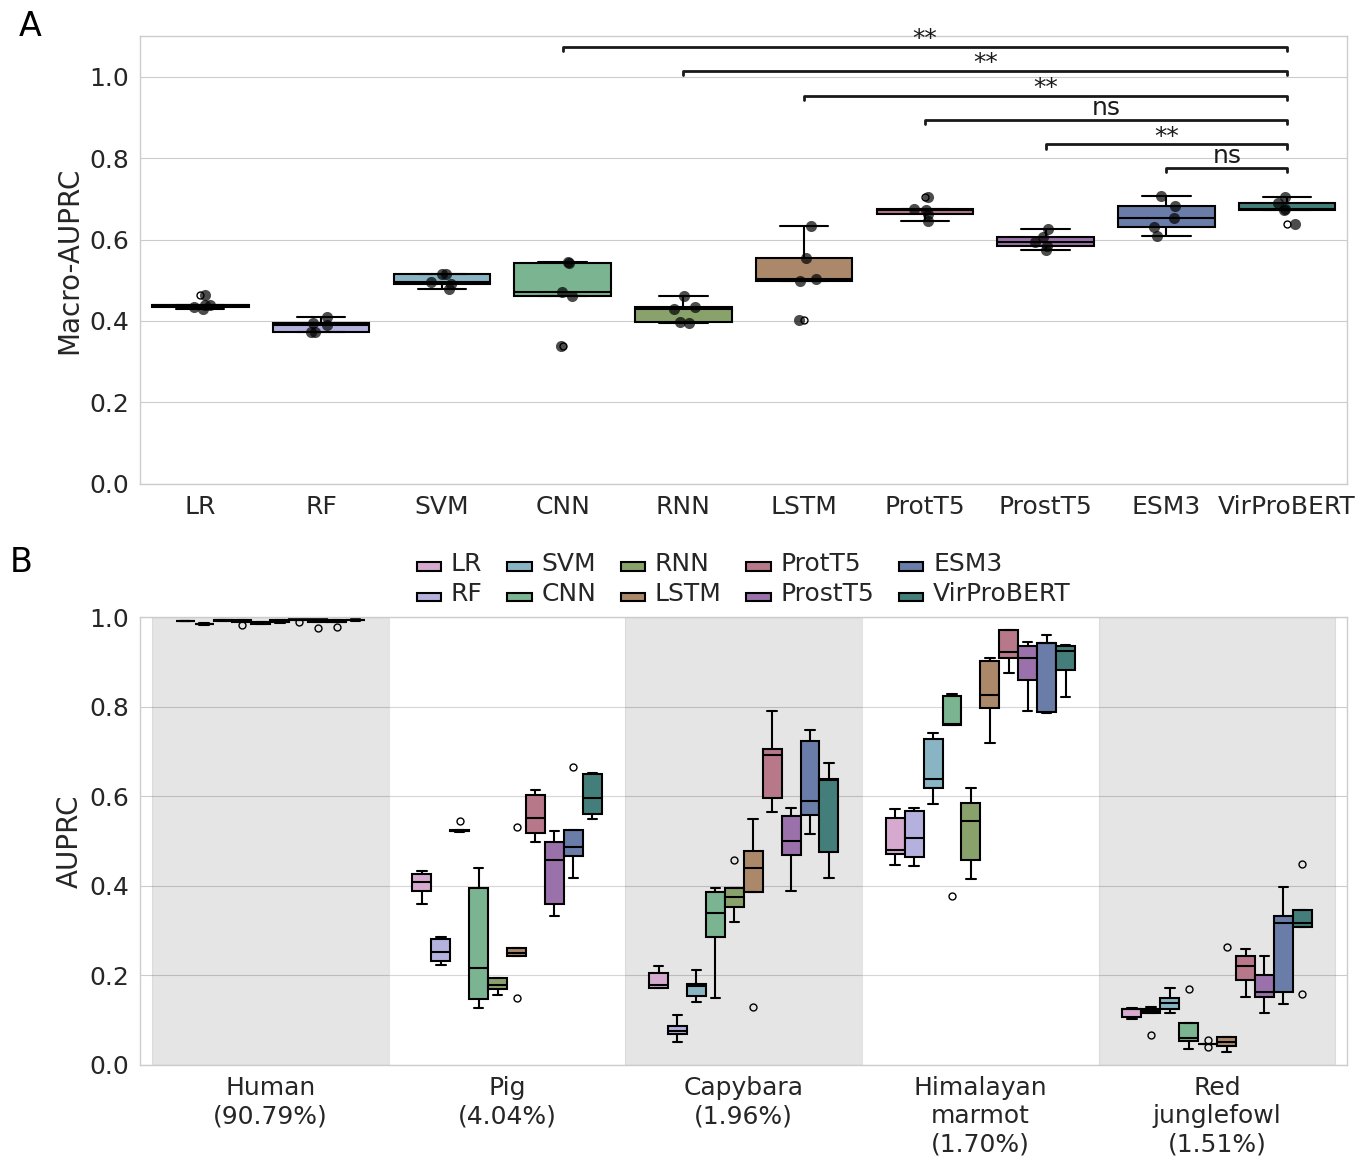

In [75]:
figure_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "output/visualization/temp_new/host_multi_all_models_combined_aurpc_boxplot_w_stat.pdf")
combined_auprc_analysis_w_stat(output_filepaths, figure_output_filepath=figure_output_filepath)

In [29]:
metadata_formatted

NameError: name 'metadata_formatted' is not defined